In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')
np.random.seed(2)

In [3]:
# Load label's data
df = pd.read_csv('/content/drive/MyDrive/data/Camera/labels.csv')
df.dtypes

id       int64
count    int64
dtype: object

In [4]:
# Map each id to its appropriate file name
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [5]:
df.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


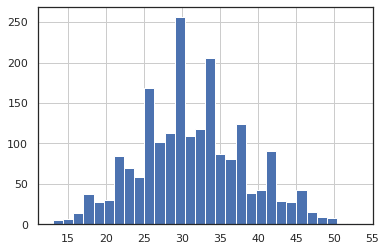

In [6]:
df['count'].hist(bins=30);

In [7]:
# Setup some constants
size = 224   #For input shape
batch_size = 64

In [8]:
# ImageDataGenerator - with defined augmentaions
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixels to [0,1]. This seems to work well with pretrained models.
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    validation_split=0.2,  # 20% of data randomly assigned to validation
    preprocessing_function=vgg16.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [9]:
flow_params = dict(dataframe=df, directory='/content/drive/MyDrive/data/Camera/frames/frames', x_col="image_name", y_col="count",
                   weight_col=None, target_size=(size, size), color_mode='rgb', class_mode="raw",
                   batch_size=batch_size, shuffle=True, seed=0 )

# The dataset is split to training and validation sets at this point
train_generator = datagen.flow_from_dataframe(subset='training', **flow_params)
valid_generator = datagen.flow_from_dataframe(subset='validation', **flow_params)

Found 1600 validated image filenames.
Found 400 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow

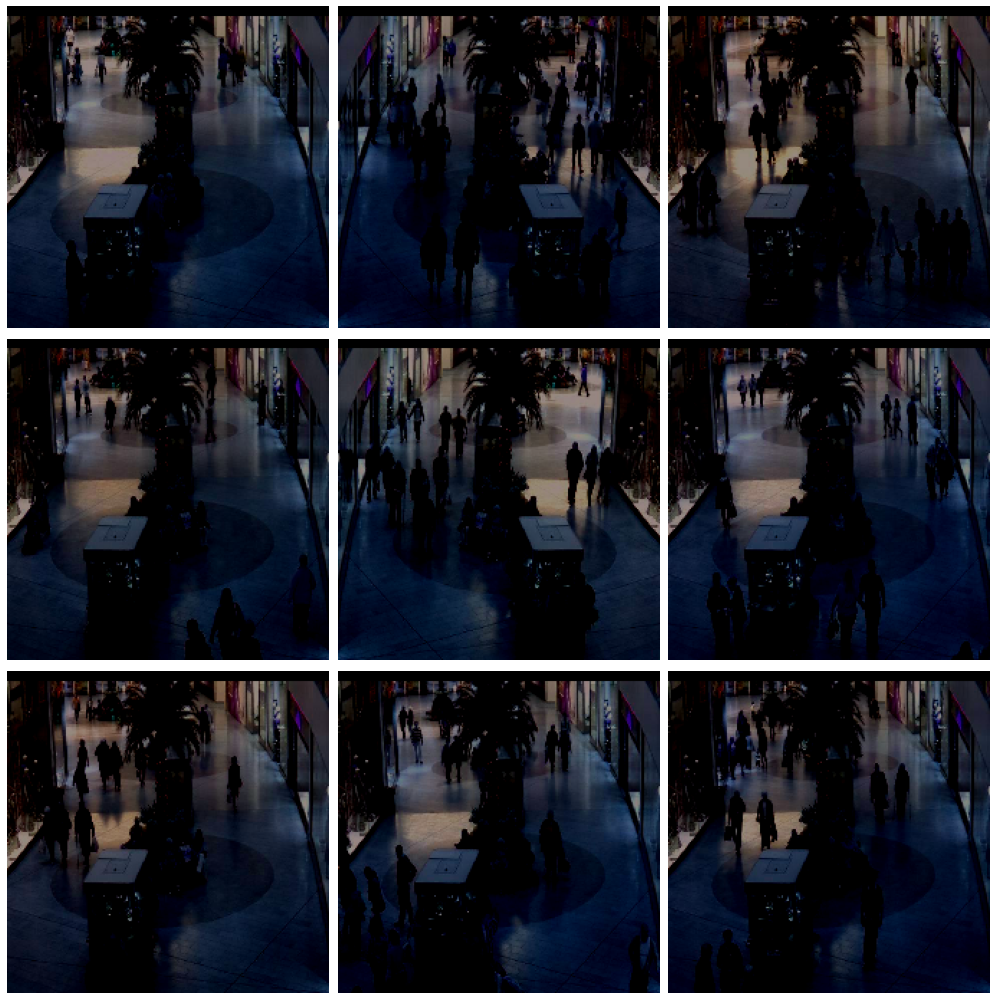

In [10]:
batch = next(train_generator)
fig, axes = plt.subplots(3, 3, figsize=(14, 14))
axes = axes.flatten()
for i in range(9):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
plt.tight_layout()

In [11]:
base_model = vgg16.VGG16(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(size, size, 3),  # 224x224 was the original size ResNet was trained on, so I decided to use this.
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
# Here we change the top (the last parts) of the network.
x = base_model.output  # Since we used pooling='avg', the output is of the pooling layer
  # We add a single fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [13]:
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
k = -11
for layer in model.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d
dense
dense_1


In [15]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss. 
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
# The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.

In [16]:
# Compile the model
model.compile(optimizer=optimizer, loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [ ]:
# Fit the model
history = model.fit_generator(generator=train_generator, epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data= valid_generator, verbose=1, callbacks=[learning_rate_reduction])
print('\nDone.')

In [83]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/data/Camera/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/data/Camera/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

In [85]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
    # print(pred_i, labels_i)

cat_labels = np.concatenate(all_labels)
cat_pred = np.concatenate(all_pred)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [86]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


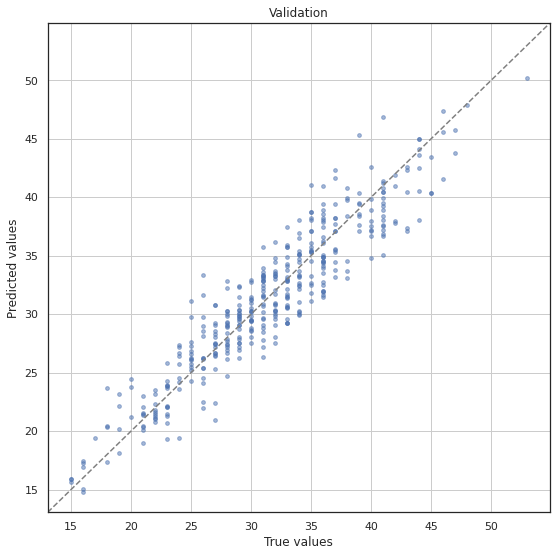

In [87]:
df_predictions = pd.DataFrame({'True values': cat_labels, 'Predicted values': cat_pred})
ax = df_predictions.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

In [88]:
mse = mean_squared_error(*df_predictions.T.values)
pearson_r = sc.stats.pearsonr(*df_predictions.T.values)[0]

print(f'MSE: {mse:.1f}')

MSE: 5.8


In [22]:
from keras.models import model_from_json
# import json 

# load json and create model
json_file = open('/content/drive/MyDrive/data/Camera/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/data/Camera/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [35]:
# initialize list of lists 
data = [[1,	35,	"seq_000001.jpg"],[2,	13,	"seq_000002.jpg"]
      ,[3, 51,	"seq_000003.jpg"] , [6, 18,	"seq_000006.jpg"],]
# Create the pandas DataFrame 
df2 = pd.DataFrame(data, columns = ['id',	'count',	'image_name']) 
# print dataframe. 
df2

,id,count,image_name
0,1,35,seq_000001.jpg
1,2,13,seq_000002.jpg
2,3,51,seq_000003.jpg
3,6,18,seq_000006.jpg


In [36]:
fl = dict(dataframe=df2, directory='/content/drive/MyDrive/data/Camera/test',
    x_col="image_name", y_col="count", weight_col=None, target_size=(size, size),
    color_mode='rgb', class_mode="raw", batch_size=batch_size, shuffle=True, seed=0)
test = datagen.flow_from_dataframe(**fl)
test

Found 4 validated image filenames.


In [37]:
# Predict on entire validation set, to be able to review the predictions manually
test.reset()
all_labels2 = []
all_pred2 = []
for i in range(len(test)):
  x = next(test)
  pred_i2 = loaded_model.predict(x[0])[:,0]
  pred_i2=np.round(pred_i2)
  labels_i2 = x[1]
  all_labels2.append(labels_i2)
  all_pred2.append(pred_i2)
cat_labels2 = np.concatenate(all_labels2)
cat_pred2 = np.concatenate(all_pred2)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [38]:
 #print(x)
 print("Predicted:",cat_pred2)
 print("Actual labels:",cat_labels2 )

Predicted: [52. 30. 18. 32.]
Actual labels: [51 18 13 35]


In [39]:
df_predictions = pd.DataFrame({'True values': cat_labels2, 'Predicted values': cat_pred2})
mse = mean_squared_error(*df_predictions.T.values)
pearson_r = sc.stats.pearsonr(*df_predictions.T.values)[0]

print(f'MSE: {mse:.1f}')

MSE: 44.8
